# Worksheet 6 - Classification

### Lecture and Tutorial Learning Goals:

After completing this week's lecture and tutorial work, you will be able to:

* Recognize situations where a simple classifier would be appropriate for making predictions.
* Explain the k-nearest neighbour classification algorithm.
* Interpret the output of a classifier.
* Compute, by hand, the distance between points when there are two explanatory variables/predictors.
* Describe what a training data set is and how it is used in classification.
* Given a dataset with two explanatory variables/predictors, use k-nearest neighbour classification in R using the `tidymodels` framework to predict the class of a single new observation.

This worksheet covers parts of [the Classification I chapter](https://datasciencebook.ca/classification1.html) of the online textbook. You should read this chapter before attempting the worksheet.

In [1]:
 ### Run this cell before continuing.
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)
source('tests.R')
source('cleanup.R')

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.3     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.4     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

**Question 0.1** Multiple Choice: 
<br> {points: 1}

**Which of the following statements is NOT true of a training data set (in the context of classification)?**

A. A training data set is a collection of observations for which we know the true classes.

B. We can use a training set to explore and build our classifier.

C. The training data set is the underlying collection of observations for which we don't know the true classes.

*Assign your answer to an object called `answer0.1`. Make sure the correct answer is an uppercase letter. Remember to surround your answer with quotation marks (e.g. "D").*

In [2]:
# Replace the fail() with your answer. 

# your code here
answer0.1 <- "C"

In [3]:
test_0.1()

Test passed 🌈
[1] "Success!"


**Question 0.2** Multiple Choice
<br> {points: 1}

(Adapted from James et al, "[An introduction to statistical learning](http://www-bcf.usc.edu/~gareth/ISL/)" (page 53))

Consider the scenario below: 

We collect data on 20 similar products. For each product we have recorded whether it was a success or failure (labelled as such by the Sales team), price charged for the product, marketing budget, competition price, customer data, and ten other variables. 

**Which of the following is a classification problem?**

A. We are interested in comparing the profit margins for products that are a success and products that are a failure. 

B. We are considering launching a new product and wish to know whether it will be a success or a failure. 

C. We wish to group customers based on their preferences and use that knowledge to develop targeted marketing programs. 

*Assign your answer to an object called `answer0.2`. Make sure the correct answer is an uppercase letter. Remember to surround your answer with quotation marks (e.g. "F").*

In [4]:
# Replace the fail() with your answer. 

# your code here
answer0.2 <- "B"

In [5]:
test_0.2()

Test passed 🥳
[1] "Success!"


## 1. Breast Cancer Data Set 
We will work with the breast cancer data from this week's pre-reading. 
> Note that the breast cancer data in this worksheet have been **standardized (centred and scaled)** for you already. We will implement these steps in future worksheets/tutorials later, but for now, know the data has been standardized. Therefore the variables are unitless and hence why we have zero and negative values for variables like Radius. 

**Question 1.0**
<br> {points: 1}

Read the `clean-wdbc-data.csv` file (found in the `data` directory) using the `read_csv()` function into the notebook and store it as a data frame. Name it `cancer`.

In [6]:
# your code here
cancer <- read_csv("data/clean-wdbc-data.csv")
cancer

Rows: 569 Columns: 12
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (1): Class
dbl (11): ID, Radius, Texture, Perimeter, Area, Smoothness, Compactness, Con...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


ID,Class,Radius,Texture,Perimeter,Area,Smoothness,Compactness,Concavity,Concave_points,Symmetry,Fractal_dimension
<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
842302,M,1.885031,-1.35809849,2.301575,1.999478,1.3065367,2.6143647,2.1076718,2.294058,2.7482041,1.9353117
842517,M,1.804340,-0.36887865,1.533776,1.888827,-0.3752817,-0.4300658,-0.1466200,1.086129,-0.2436753,0.2809428
84300903,M,1.510541,-0.02395331,1.346291,1.455004,0.5269438,1.0819801,0.8542223,1.953282,1.1512420,0.2012142
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
926954,M,0.5608679,1.3736451,0.5784916,0.4275294,-0.8088756,0.350427,0.3264793,0.4137047,-1.10357792,-0.3181292
927241,M,1.9595152,2.2359585,2.3015755,1.6517174,1.4291692,3.901415,3.1947936,2.2879723,1.91739590,2.2176840
92751,B,-1.4096522,0.7635178,-1.4314754,-1.0748672,-1.8573842,-1.206491,-1.3046827,-1.7435287,-0.04809589,-0.7505463


In [7]:
test_1.0()

Test passed 🥳
Test passed 🎉
Test passed 😸
Test passed 😸
Test passed 🎉
[1] "Success!"


**Question 1.1** True or False: 
<br> {points: 1}

After looking at the first six rows of the `cancer` data fame, suppose we asked you to predict the variable "area" for a new observation. **Is this a classification problem?**

*Assign your answer to an object called `answer1.1`. Make sure the correct answer is written in lower-case. Remember to surround your answer with quotation marks (e.g. "true" / "false").*

In [8]:
# Replace the fail() with your answer. 

# your code here
answer1.1 <- "false"

In [9]:
test_1.1()

Test passed 🎉
[1] "Success!"


We will be treating `Class` as a categorical variable, so we should convert it into a factor using the `as_factor()` function.

In [10]:
# run this cell
cancer <- cancer |>
        mutate(Class = as_factor(Class))

**Question 1.2** 
<br> {points: 1}

Create a scatterplot of the data with `Symmetry` on the x-axis and `Radius` on the y-axis. Modify your aesthetics by colouring for `Class`. As you create this plot, ensure you follow the guidelines for creating effective visualizations. In particular, note on the plot axes whether the data is standardized or not.

*Assign your plot to an object called `cancer_plot`.*

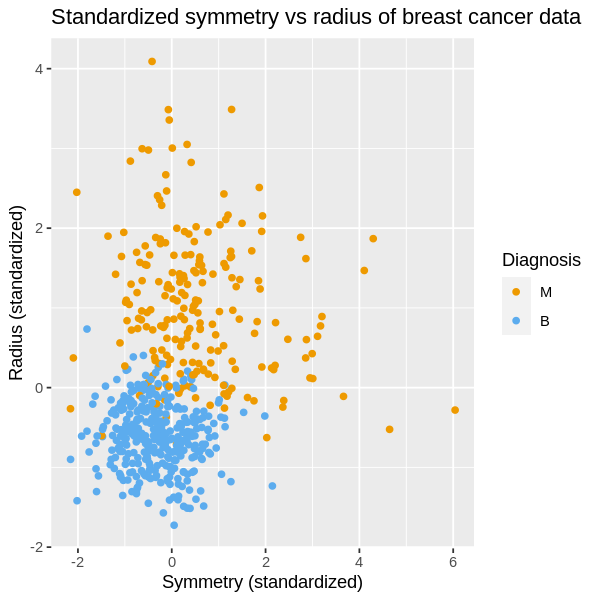

In [11]:
# your code here
cancer <- cancer |>
  mutate(Class = as_factor(Class)) |>
  mutate(Class = Class, "Malignant" = "M", "Benign" = "B")

options(repr.plot.width = 5, repr.plot.height = 5) 

cancer_plot <- cancer |>
    ggplot(aes(x = Symmetry, y = Radius, color = Class))+
    geom_point() +
    labs(x = "Symmetry (standardized)", 
         y = "Radius (standardized)",
         color = "Diagnosis") +
    ggtitle("Standardized symmetry vs radius of breast cancer data") +
    scale_color_manual(values = c("orange2", "steelblue2")) 

cancer_plot

In [12]:
test_1.2()

Test passed 🥳
Test passed 🥇
Test passed 🥇
Test passed 🎊
Test passed 😸
Test passed 🎊
[1] "Success!"


**Question 1.3** 
<br> {points: 1}

Just by looking at the scatterplot above, how would you classify an observation with `Symmetry` = 1 and `Radius` = 1 (Benign or Malignant)?

*Assign your answer to an object called `answer1.3`. Make sure the correct answer is written fully. Remember to surround your answer with quotation marks (e.g. "Benign" / "Malignant").*

In [13]:
# Replace the fail() with your answer. 

# your code here
answer1.3 <- "Malignant"

In [14]:
test_1.3()

Test passed 🎉
[1] "Success!"


We will now compute the distance between the first and second observation in the breast cancer dataset using the explanatory variables/predictors `Symmetry` and `Radius`. Recall we can calculate the distance between two points using the following formula:

$$Distance = \sqrt{(a_x -b_x)^2 + (a_y - b_y)^2}$$

**Question 1.4** 
<br> {points: 1}

First, extract the coordinates for the two observations and assign them to objects called: 

- `ax` (Symmetry value for the first row)
- `ay` (Radius value for the first row)
- `bx` (Symmetry value for the second row)
- `by` (Radius value for the second row).

*Scaffolding for `ax` is given*.
> Note we are using the function `pull()` because we want the numeric value (and object) as our output rather than a `tibble` type object so we can do calculations later on. You can verify the object type in R with the `class()` function. Check the class of `ax` with and without the `pull()` function and see what you get! 

In [15]:
ax <- slice(cancer, 1) |> 
    pull(Symmetry)
ay <- slice(cancer, 1) |>
    pull(Radius)
bx <- slice(cancer, 2) |>
    pull(Symmetry)
by <- slice(cancer, 2) |>
    pull(Radius)


In [16]:
test_1.4()

Test passed 🥳
Test passed 😸
Test passed 🌈
Test passed 🥳
[1] "Success!"


**Question 1.5**
<br> {points: 1}

Plug the coordinates into the distance equation. 

*Assign your answer to an object called `answer1.5`.*

Fill in the `...` in the cell below. Copy and paste your finished answer into the `fail()`.

In [17]:
answer1.5 <- sqrt((ax - bx)^2 + (ay - by)^2)

answer1.5

[1] 2.992967

In [18]:
test_1.5()

Test passed 🎊
[1] "Success!"


**Question 1.6**
<br> {points: 1}

Now we'll do the same thing *with 3 explanatory variables/predictors*: `Symmetry`, `Radius` and `Concavity`. Again, use the first two rows in the data set as the points you are calculating the distance between (point $a$ is row 1, and point $b$ is row 2).


Find the coordinates for the third variable (Concavity) and assign them to objects called `az` and `bz`. Use the scaffolding given in **Question 1.4** as a guide.

In [19]:
az <- slice(cancer, 1) |>
    pull(Concavity)
bz <- slice(cancer, 2) |>
    pull(Concavity)

In [20]:
test_1.6()

Test passed 🥇
Test passed 🥇
Test passed 🌈
Test passed 🌈
[1] "Success!"


**Question 1.7**
<br> {points: 1}

Again, calculate the distance between the first and second observation in the breast cancer dataset using 3 explanatory variables/predictors: `Symmetry`, `Radius` and `Concavity`.

*Assign your answer to an object called `answer1.7`. Use the scaffolding given to calculate `answer1.5` as a guide.*

In [21]:
answer1.7 <- sqrt((ax - bx)^2 + (ay - by)^2 + (az - bz)^2)

In [22]:
test_1.7()

Test passed 🥇
[1] "Success!"


**Question 1.8**
<br> {points: 1}

Let's do this without explicitly making coordinate variables!

Create a vector of the coordinates for each point. Name one vector `point_a` and the other vector `point_b`. Within the vector, the order of coordinates should be: `Symmetry`, `Radius`, `Concavity`.

Fill in the `...` in the cell below. Copy and paste your finished answer into the `fail()`.


> Here will use `select` and `as.numeric` instead of `pull` because we need to get the numeric values of 3 columns. `pull`, that we used previously, only works to extract the numeric values from a single column.

In [23]:
# This is only the scaffolding for one vector 
# You need to make another one for row number 2!

point_a <- slice(cancer, 1) |>
    select(Symmetry, Radius, Concavity) |>
    as.numeric()
point_b <- slice(cancer, 2) |>
    select(Symmetry, Radius, Concavity) |>
    as.numeric()


# your code here
point_a
point_b

[1] 2.748204 1.885031 2.107672

[1] -0.2436753  1.8043398 -0.1466200

In [24]:
test_1.8()

Test passed 🥳
Test passed 🥳
[1] "Success!"


**Question 1.9**
<br> {points: 1}

Compute the squared differences between the two vectors, `point_a` and `point_b`. The result should be a vector of length 3 named `dif_square`. *Hint: `^` is the exponent symbol in R.*

In [25]:
# your code here
dif_square <- ((point_a) - (point_b))^2
dif_square

[1] 8.951342184 0.006511068 5.081831410

In [26]:
test_1.09()

Test passed 😸
[1] "Success!"


**Question 1.09.1**
<br> {points: 1}

Sum the squared differences between the two vectors, `point_a` and `point_b`. The result should be a single number named `dif_sum`. 

*Hint: the `sum` function in R returns the sum of the elements of a vector*

In [27]:
# your code here
dif_sum <- sum(dif_square)
dif_sum

[1] 14.03968

In [28]:
test_1.09.1()

Test passed 🎉
[1] "Success!"


**Question 1.09.2**
<br> {points: 1}

Square root the sum of your squared differences. The result should be a double named `root_dif_sum`. 

In [29]:
# your code here
root_dif_sum <- sqrt(dif_sum)
root_dif_sum

[1] 3.746957

In [30]:
test_1.09.2()

Test passed 😀
[1] "Success!"


**Question 1.09.3**
<br> {points: 1}

If we have more than a few points, calculating distances as we did in the previous questions is VERY tedious. Let's use the `dist()` function to find the distance between the first and second observation in the breast cancer dataset using Symmetry, Radius and Concavity. 

Fill in the `...` in the cell below. Copy and paste your finished answer into the `fail()`.

*Assign your answer to an object called `dist_cancer_two_rows`.*

In [31]:
dist_cancer_two_rows <- cancer  |> 
    slice(1,2)  |> 
    select(Symmetry, Radius, Concavity)  |> 
    dist()

dist_cancer_two_rows

         1
2 3.746957

In [32]:
test_1.09.3()

Test passed 🎊
[1] "Success!"


**Question 1.09.4** True or False: 
<br> {points: 1}

Compare `answer1.7`, `root_dif_sum`, and `dist_cancer_two_rows`. 

**Are they all the same value?** 

*Assign your answer to an object called `answer1.09.4`. Make sure the correct answer is written in lower-case. Remember to surround your answer with quotation marks (e.g. "true" / "false").*

In [33]:
# Replace the fail() with your answer. 

# your code here
answer1.09.4 <- "true"

In [34]:
test_1.09.4()

Test passed 🥳
[1] "Success!"


## 2. Classification - A Simple Example Done Manually

**Question 2.0.0**
<br> {points: 1}

Let's take a random sample of 5 observations from the breast cancer dataset using the `sample_n` function. To make this random sample reproducible, we will use `set.seed(20)`. This means that the random number generator will start at the same point each time when we run the code and we will always get back the same random samples. 

We will focus on the predictors Symmetry and Radius only. Thus, we will need to select the columns `Symmetry` and `Radius` and `Class`. Save these 5 rows and 3 columns to a data frame named `small_sample`.

Fill in the `...` in the scaffolding provided below.

In [35]:
set.seed(20)                           
small_sample <- sample_n(cancer, 5) |>  
    select(Symmetry, Radius, Class) 

small_sample

Symmetry,Radius,Class
<dbl>,<dbl>,<fct>
-0.4117765,-0.05983351,B
3.6614466,-0.10948962,M
-0.9241621,-0.82950329,B
-0.4796636,-0.79019220,B
0.9201028,0.12844593,M


In [36]:
test_2.0.0()

Test passed 😀
Test passed 😸
Test passed 🥇
Test passed 😀
[1] "Success!"


**Question 2.0.1**
<br> {points: 1}

Finally, create a scatter plot where `Symmetry` is on the x-axis, and `Radius` is on the y-axis. Color the points by `Class`. Name your plot `small_sample_plot`.

Fill in the `...` in the scaffolding provided below.

As you create this plot, ensure you follow the guidelines for creating effective visualizations. In particular, note on the plot axes whether the data is standardized or not.

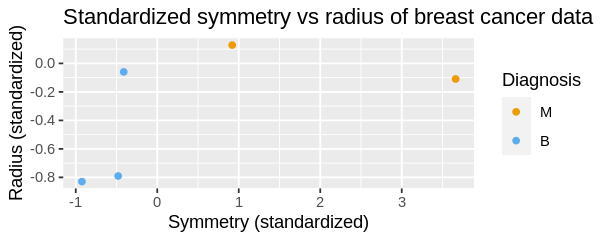

In [37]:
options(repr.plot.width = 5, repr.plot.height = 2) 

small_sample_plot <- small_sample|>   
    ggplot(aes(x = Symmetry, y = Radius, color = Class)) + 
        geom_point() +
    labs(x = "Symmetry (standardized)", 
         y = "Radius (standardized)",
         color = "Diagnosis") +
    ggtitle("Standardized symmetry vs radius of breast cancer data") +
    scale_color_manual(values = c("orange2", "steelblue2")) 

small_sample_plot

In [38]:
test_2.0.1()

Test passed 🥇
Test passed 🎉
Test passed 🥳
Test passed 🎊
Test passed 🌈
Test passed 😀
Test passed 🥇
[1] "Success!"


**Question 2.1** 
<br> {points: 1}

Suppose we are interested in classifying a new observation with `Symmetry = 0.5` and `Radius = 0`, but unknown `Class`. Using the `small_sample` data frame, add another row with `Symmetry = 0.5`, `Radius = 0`, and `Class = "unknown"`.

Fill in the `...` in the scaffolding provided below.

*Assign your answer to an object called `newData`.*

In [39]:
newData <- small_sample |>
    add_row(Symmetry = 0.5, Radius = 0, Class = "unknown")

newData

Symmetry,Radius,Class
<dbl>,<dbl>,<chr>
-0.4117765,-0.05983351,B
3.6614466,-0.10948962,M
-0.9241621,-0.82950329,B
-0.4796636,-0.79019220,B
0.9201028,0.12844593,M
0.5000000,0.00000000,unknown


In [40]:
test_2.1()

Test passed 😀
Test passed 😀
Test passed 🎉
Test passed 🌈
Test passed 🎉
[1] "Success!"


**Question 2.2**
<br> {points: 1}

Compute the distance between each pair of the 6 observations in the `newData` dataframe using the `dist()` function based on two variables: `Symmetry` and `Radius`. Fill in the `...` in the scaffolding provided below.


*Assign your answer to an object called `dist_matrix`.*

In [41]:
dist_matrix <- newData |>
    select(Symmetry, Radius) |> 
    dist() |>                   
    as.matrix() 

dist_matrix

,1,2,3,4,5,6
1,0.0000000,4.073526,0.9246246,0.7335070,1.3451214,0.9137376
2,4.0735258,0.000000,4.6417914,4.1966832,2.7516503,3.1633420
3,0.9246246,4.641791,0.0000000,0.4462335,2.0782155,1.6481242
4,0.7335070,4.196683,0.4462335,0.0000000,1.6742885,1.2586280
5,1.3451214,2.751650,2.0782155,1.6742885,0.0000000,0.4393002
6,0.9137376,3.163342,1.6481242,1.2586280,0.4393002,0.0000000


In [42]:
test_2.2()

Test passed 🥇
Test passed 😀
Test passed 🥇
Test passed 🥳
[1] "Success!"


**Question 2.3** Multiple Choice:
<br> {points: 1}

In the table above, the row and column numbers reflect the row number from the data frame the `dist` function was applied to. Thus numbers 1 - 5 were the points/observations from rows 1 - 5 in the `small_sample` data frame. Row 6 was the new observation that we do not know the diagnosis class for.  The values in `dist_matrix` are the distances between the points of the row and column number. For example, the distance between the point 2 and point 4 is 4.196683. And the distance between point 3 and point 3 (the same point) is 0.

**Which observation is the nearest to our new point?**

*Assign your answer to an object called `answer2.3`. Make sure your answer is a number. Remember to surround your answer with quotation marks (e.g. "8").*

In [43]:
answer2.3 <- "5"

In [44]:
test_2.3()

Test passed 😀
[1] "Success!"


**Question 2.4** Multiple Choice: 
<br> {points: 1}

Use the K-nearest neighbour classification algorithm with K = 1 to classify the new observation using your answers to **Questions 2.2 & 2.3**. Is the new data point predicted to be benign or malignant?

*Assign your answer to an object called `answer2.4`. Make sure the correct answer is written fully as either "Benign" or "Malignant". Remember to surround your answer with quotation marks.* 

In [45]:
# Replace the fail() with your answer. 

# your code here
answer2.4 <- "Malignant"

In [46]:
test_2.4()

Test passed 🎉
[1] "Success!"


**Question 2.5** Multiple Choice:
<br> {points: 1}

Using your answers to **Questions 2.2 & 2.3**, what are the three closest observations to your new point?

A. 1, 3, 2

B. 5, 1, 4

C. 5, 2, 4

D. 3, 4, 2

*Assign your answer to an object called `answer2.5`. Make sure the correct answer is an uppercase letter. Remember to surround your answer with quotation marks (e.g. "F").*

In [47]:
# Replace the fail() with your answer. 

# your code here
answer2.5 <- "B"

In [48]:
test_2.5()

Test passed 🥇
[1] "Success!"


**Question 2.6** Multiple Choice: 
<br> {points: 1}

We will now use the K-nearest neighbour classification algorithm with K = 3 to classify the new observation using your answers to **Questions 2.2 & 2.3**. Is the new data point predicted to be benign or malignant?

*Assign your answer to an object called `answer2.6`. Make sure the correct answer is written fully. Remember to surround your answer with quotation marks (e.g. "Benign" / "Malignant").*

In [49]:
# Replace the fail() with your answer. 

# your code here
answer2.6 <- "Benign"

In [50]:
test_2.6()

Test passed 🥳
[1] "Success!"


**Question 2.7**
<br> {points: 1}

Compare your answers in 2.4 and 2.6. Are they the same?

*Assign your answer to an object called `answer2.7`. Make sure the correct answer is written in lower-case. Remember to surround your answer with quotation marks (e.g. "yes" / "no").* 

In [51]:
# Replace the fail() with your answer. 

# your code here
answer2.7 <- "no"

In [52]:
test_2.7()

Test passed 😸
[1] "Success!"


## 3. Using `tidymodels` to perform k-nearest neighbours

Now that we understand how K-nearest neighbours (k-nn) classification works, let's get familar with the `tidymodels` R package. The benefit of using `tidymodels` is that it will keep our code simple, readable and accurate. Coding less and in a tidier format means that there is less chance for errors to occur.  

We'll again focus on `Radius` and `Symmetry` as the two predictors. This time, we would like to predict the class of a new observation with `Symmetry = 1` and `Radius = 0`. This one is a bit tricky to do visually from the plot below, and so is a motivating example for us to compute the prediction using k-nn with the `tidymodels` package. Let's use `K = 7`.

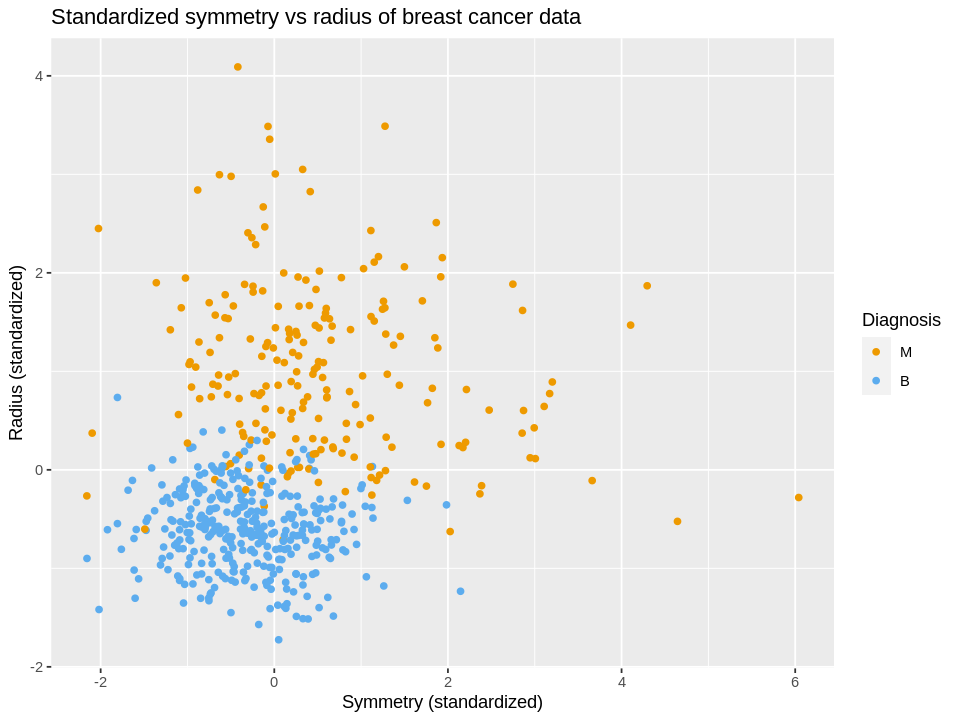

In [53]:
options(repr.plot.width = 8, repr.plot.height = 6) # you can change the size of the plot if it is too small or too large 
cancer_plot

**Question 3.1** 
<br> {points: 1}

Create a **model specification** for K-nearest neighbours classification by using the `nearest_neighbor()` function. Specify that we want to set `k = 7` and use the *straight-line distance*. Furthermore, specify the *computational engine* to be `"kknn"` for training the model with the `set_engine()` function. Finally, identify that this is a *classification* problem with the `set_mode()` function. 

Name your model specification `knn_spec`.

In [54]:
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 7) |>
       set_engine("kknn") |>
       set_mode("classification")

knn_spec

K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = 7
  weight_func = rectangular

Computational engine: kknn 


In [55]:
test_3.1()

Test passed 🥇
Test passed 😸
Test passed 😀
Test passed 🌈
Test passed 🥇
[1] "Success!"


**Question 3.2**
<br> {points: 1}

To train the model on the breast cancer dataset, pass `knn_spec` and the `cancer` dataset to the `fit()` function. Specify `Class` as your target variable and the `Symmetry` and `Radius` variables as your predictors. Name your fitted model as `knn_fit`.

In [56]:
cancer
knn_fit <- knn_spec |> 
        fit(Class ~ Symmetry + Radius, data = cancer)

knn_fit

ID,Class,Radius,Texture,Perimeter,Area,Smoothness,Compactness,Concavity,Concave_points,Symmetry,Fractal_dimension,Malignant,Benign
<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
842302,M,1.885031,-1.35809849,2.301575,1.999478,1.3065367,2.6143647,2.1076718,2.294058,2.7482041,1.9353117,M,B
842517,M,1.804340,-0.36887865,1.533776,1.888827,-0.3752817,-0.4300658,-0.1466200,1.086129,-0.2436753,0.2809428,M,B
84300903,M,1.510541,-0.02395331,1.346291,1.455004,0.5269438,1.0819801,0.8542223,1.953282,1.1512420,0.2012142,M,B
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
926954,M,0.5608679,1.3736451,0.5784916,0.4275294,-0.8088756,0.350427,0.3264793,0.4137047,-1.10357792,-0.3181292,M,B
927241,M,1.9595152,2.2359585,2.3015755,1.6517174,1.4291692,3.901415,3.1947936,2.2879723,1.91739590,2.2176840,M,B
92751,B,-1.4096522,0.7635178,-1.4314754,-1.0748672,-1.8573842,-1.206491,-1.3046827,-1.7435287,-0.04809589,-0.7505463,M,B


parsnip model object


Call:
kknn::train.kknn(formula = Class ~ Symmetry + Radius, data = data,     ks = min_rows(7, data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.07029877
Best kernel: rectangular
Best k: 7

In [57]:
test_3.2()

Test passed 🎉
Test passed 🥇
Test passed 🥇
Test passed 🥳
Test passed 🥳
[1] "Success!"


**Question 3.3**
<br>{points: 1}

Now we will make our prediction on the `Class` of a new observation with a `Symmetry` of 1 and a `Radius` of 0. First, create a tibble with these variables and values and call it `new_obs`. Next, use the `predict()` function to obtain our prediction by passing `knn_fit` and `new_obs` to it. Name your predicted class as `class_prediction`.

In [58]:
new_obs <- tibble(Symmetry = 1, Radius = 0)
class_prediction <- predict(knn_fit, new_obs)


class_prediction

.pred_class
<fct>
M


In [59]:
test_3.3()

Test passed 🎉
Test passed 🎉
Test passed 🥇
Test passed 😸
Test passed 🥇
[1] "Success!"


**Question 3.4**
<br> {points: 1}

Let's perform K-nearest neighbour classification again, but with three predictors. Use the `tidymodels` package and `K = 7` to classify a new observation where we measure `Symmetry = 1`, `Radius = 0` and `Concavity = 1`. Use the scaffolding from **Questions 3.2** and **3.3** to help you.

- Pass the same `knn_spec` from before to `fit`, but this time specify `Symmetry`, `Radius`, and `Concavity` as the predictors. Store the output in `knn_fit_2`. 
- store the new observation values in an object called `new_obs_2`
- store the output of `predict` in an object called `class_prediction_2`

In [60]:
# your code here
knn_fit_2 <- knn_spec |>
    fit(Class ~ Symmetry + Radius + Concavity, data = cancer)
new_obs_2 <- tibble(Symmetry = 1, Radius = 0, Concavity  = 1)
class_prediction_2 <- predict(knn_fit_2, new_obs_2)
class_prediction_2

.pred_class
<fct>
M


In [61]:
test_3.4()

Test passed 😀
Test passed 😀
Test passed 😀
Test passed 🎊
Test passed 🎉
Test passed 🎉
Test passed 🥇
Test passed 🥳
Test passed 🎉
Test passed 🥳
Test passed 🎉
Test passed 🌈
Test passed 🥳
Test passed 🎊
[1] "Success!"


**Question 3.5**
<br>{points: 1}

Finally, we will perform K-nearest neighbour classification again, using the `tidymodels` package and `K = 7` to classify a new observation where we use **all the predictors** in our data set (we give you the values in the code below). 

But we first have to do one important thing: we need to remove the `ID` variable from the analysis (it's not a numerical measurement that we should use for classification). Thankfully, `tidymodels` provides a nice way of combining data preprocessing and training into a single consistent workflow.

We will first create a `recipe` to remove the `ID` variable using the `step_rm` preprocessing step. Do so below using the provided scaffolding. Name the recipe object `knn_recipe`.

*Hint: If you want to find out about the available preprocessing steps that you can include in a `recipe`, visit [the tidymodels page](https://recipes.tidymodels.org/reference/index.html)*.

In [81]:
knn_recipe <- recipe(Class ~ ., data = cancer) |>
step_rm(ID)
knn_recipe



── Recipe ──────────────────────────────────────────────────────────────────────



── Inputs 

Number of variables by role

outcome:    1
predictor: 13



── Operations 

• Variables removed: ID



In [82]:
test_3.5()

Test passed 😀
Test passed 🌈
Test passed 🥇
── Failure (???): cancer does not contain the correct data. ────────────────────
dim(bake(prep(knn_recipe), cancer)) not equal to c(569, 11).
1/2 mismatches
[2] 13 - 11 == 2



ERROR: [1m[33mError[39m in `reporter$stop_if_needed()`:[22m
[33m![39m Test failed


You can examine the output of a recipe by using the `prep` and `bake` functions. For example, let's see if `step_rm` above actually removed the `ID` variable. Run the below code to see!

*Note: You have to pass the `cancer` data to `bake()` again, even though we already specified it in the `recipe` above. Why? This is because `tidymodels` is flexible enough to let you compute preprocessing steps using one dataset (`prep`), and applying those steps to another (`bake`). For example, if we apply the `step_center` preprocessing step (which shifts a variable to have mean 0), we need to compute the shift value (`prep`) before subtracting it from each observation (`bake`). This will be very useful in the next chapter when we have to split our dataset into two subsets, and only `prep` using one of them.*

In [83]:
preprocessed_data <- knn_recipe |> 
                        prep() |> 
                        bake(cancer)
preprocessed_data

Radius,Texture,Perimeter,Area,Smoothness,Compactness,Concavity,Concave_points,Symmetry,Fractal_dimension,Malignant,Benign,Class
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<fct>,<fct>
1.885031,-1.35809849,2.301575,1.999478,1.3065367,2.6143647,2.1076718,2.294058,2.7482041,1.9353117,M,B,M
1.804340,-0.36887865,1.533776,1.888827,-0.3752817,-0.4300658,-0.1466200,1.086129,-0.2436753,0.2809428,M,B,M
1.510541,-0.02395331,1.346291,1.455004,0.5269438,1.0819801,0.8542223,1.953282,1.1512420,0.2012142,M,B,M
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
0.5608679,1.3736451,0.5784916,0.4275294,-0.8088756,0.350427,0.3264793,0.4137047,-1.10357792,-0.3181292,M,B,M
1.9595152,2.2359585,2.3015755,1.6517174,1.4291692,3.901415,3.1947936,2.2879723,1.91739590,2.2176840,M,B,M
-1.4096522,0.7635178,-1.4314754,-1.0748672,-1.8573842,-1.206491,-1.3046827,-1.7435287,-0.04809589,-0.7505463,M,B,B


**Question 3.6**
<br> {points: 1}

Create a **workflow** that includes the new recipe (`knn_recipe`) and the model specification (`knn_spec`) using the scaffolding below. Name the workflow object `knn_workflow`.

In [84]:
knn_workflow <- workflow() |>
                   add_recipe(knn_recipe) |>
                   add_model(knn_spec)


knn_workflow  

══ Workflow ════════════════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
1 Recipe Step

• step_rm()

── Model ───────────────────────────────────────────────────────────────────────
K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = 7
  weight_func = rectangular

Computational engine: kknn 


In [85]:
test_3.6()

Test passed 🎊
Test passed 🎊
Test passed 🎊
Test passed 🌈
Test passed 😀
[1] "Success!"


**Question 3.7**
{points: 1}

Finally, `fit` the workflow and predict the class label for the new observation named `new_obs_all`. Name the `fit` object `knn_fit_all`, and the class prediction `class_prediction_all`.

In [86]:
new_obs_all <- tibble(ID = NA, Radius = 0, 
                        Texture = 0, 
                        Perimeter = 0, 
                        Area = 0, 
                        Smoothness = 0.5, 
                        Compactness = 0,
                        Concavity = 1,
                        Concave_points = 0,
                        Symmetry = 1, 
                        Fractal_dimension = 0)

knn_fit_all <- knn_workflow |>
             fit(data = cancer)
class_prediction_all <- predict(knn_fit_all, new_obs_all)

class_prediction_all

ERROR: Error in `contrasts<-`(`*tmp*`, value = contr.funs[1 + isOF[nn]]): contrasts can be applied only to factors with 2 or more levels


In [ ]:
test_3.7()

## 4. Reviewing Some Concepts

We will conclude with two multiple choice questions to reinforce some key concepts when doing classification with K-nearest neighbours.

**Question 4.0**
<br> {points: 1}

In the K-nearest neighbours classification algorithm, we calculate the distance between the new observation (for which we are trying to predict the class/label/outcome) and each of the observations in the training data set so that we can:

A. Find the `K` nearest neighbours of the new observation

B. Assess how well our model fits the data

C. Find outliers

D. Assign the new observation to a cluster

*Assign your answer (e.g. "E") to an object called: `answer4.0`. Make sure your answer is an uppercase letter and is surrounded with quotation marks.*

In [87]:
# Replace the fail() with your answer. 

# your code here
answer4.0 <- "A"

In [88]:
test_4.0()

Test passed 🌈
[1] "Success!"


**Question 4.1**
<br> {points: 1}

In the K-nearest neighbours classification algorithm, we choose the label/class for a new observation by:

A. Taking the mean (average value) label/class of the K nearest neighbours 

B. Taking the median (middle value) label/class of the K nearest neighbours 

C. Taking the mode (value that appears most often, *i.e.*, the majority vote) label/class of the K nearest neighbours 

*Assign your answer (e.g., "E") to an object called `answer4.1`. Make sure your answer is an uppercase letter and is surrounded with quotation marks.*

In [89]:
# Replace the fail() with your answer. 

# your code here
answer4.1 <- "C"

In [90]:
test_4.1()

Test passed 😀
[1] "Success!"


In [ ]:
source('cleanup.R')